In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [2]:
import os
DATASET = "E:/4-2/Eurosat Dataset/2750"

LABELS = os.listdir(DATASET)
print(LABELS)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


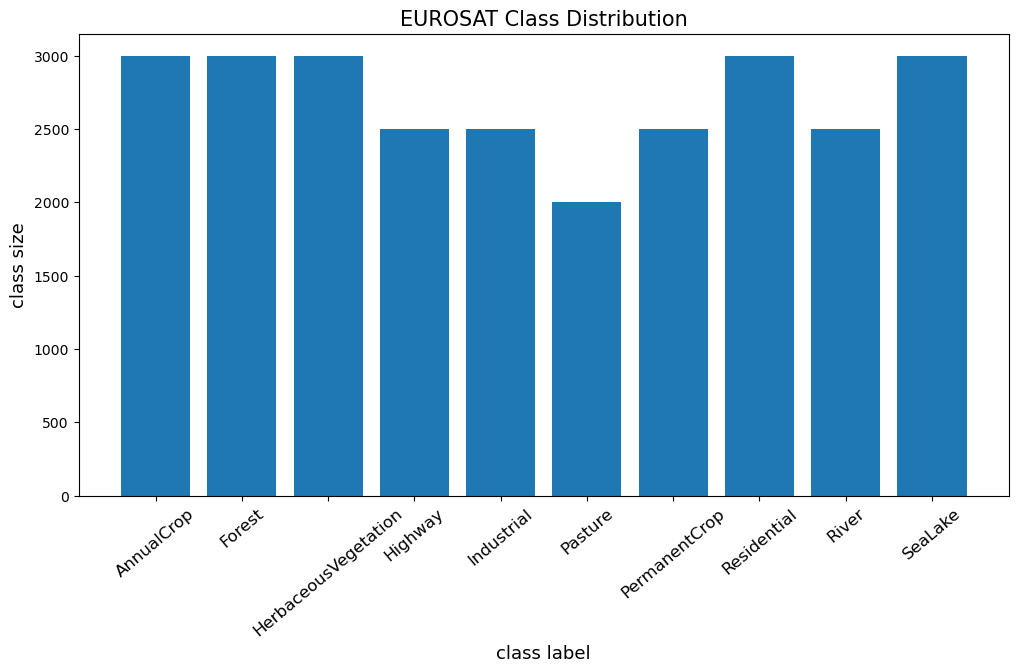

In [3]:
# plot class distributions of whole dataset
import matplotlib.pyplot as plt
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

In [4]:
import PIL
img_paths = [os.path.join(DATASET, l, f"{l}_1000.jpg") for l in LABELS]
img_paths += [os.path.join(DATASET, l, f"{l}_2000.jpg") for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i, path in enumerate(paths[:20]):
        label = os.path.basename(os.path.dirname(path))
        plt.subplot(4, 5, i+1)
        img = PIL.Image.open(path)
        plt.imshow(np.asarray(img))
        plt.title(label)
        plt.xticks([])  
        plt.yticks([])  
    plt.show()

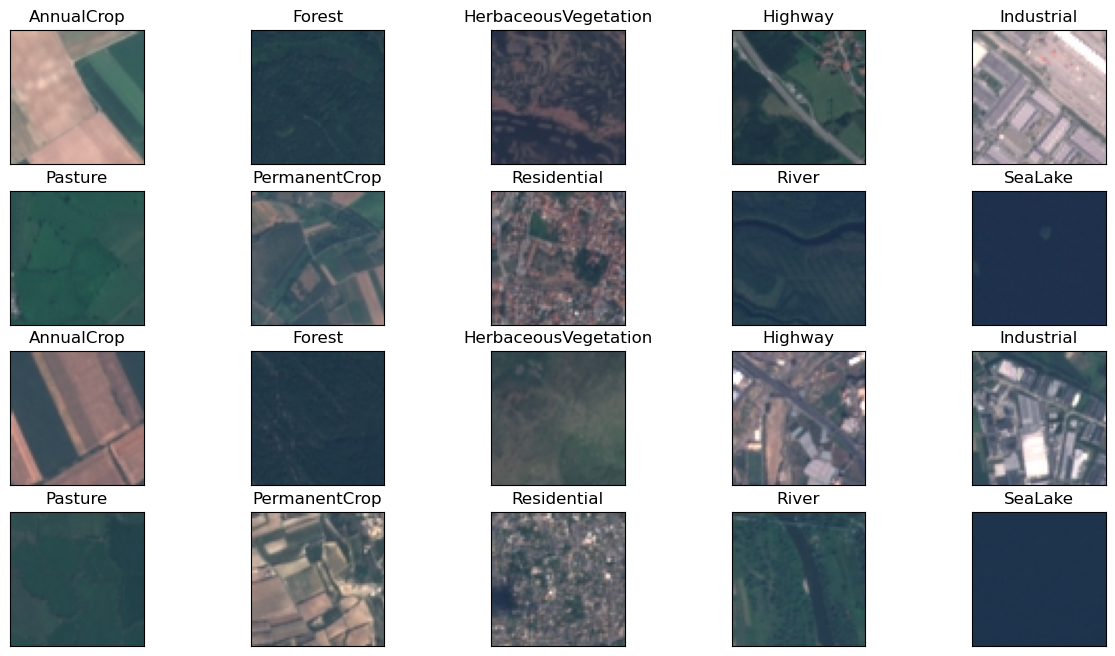

In [5]:
plot_sat_imgs(img_paths)

In [6]:
#Preprocessing

In [7]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = 'E:/4-2/Eurosat Dataset/RF/Training'
TEST_DIR = 'E:/4-2/Eurosat Dataset/RF/Testing'
BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

In [8]:
import pandas as pd
from tqdm import tqdm
import shutil

# map each image path to their class label in 'data'
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
        data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

# split the list of image paths
for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub('E:/4-2/Eurosat Dataset/2750', 'E:/4-2/Eurosat Dataset/RF/Training', i) for i in train_paths]
    new_test_paths = [re.sub('E:/4-2/Eurosat Dataset/2750', 'E:/4-2/Eurosat Dataset/RF/Testing', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])
    
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

moving training files..


100%|███████████████████████████████████████████████████████████████████████████| 21600/21600 [02:14<00:00, 160.16it/s]


moving testing files..


100%|█████████████████████████████████████████████████████████████████████████████| 5400/5400 [00:31<00:00, 168.81it/s]


In [9]:
# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)
# The validation set is optional if we choose to do that
"""
valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',    
    color_mode='rgb',
    shuffle=True,
    seed=69
)
"""
# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [10]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [11]:
np.save('class_indices', train_generator.class_indices)

In [12]:
# Machine Learning for Image Classification

In [13]:
# Using image data generator api in keras for making image dataset 
rf_gen = ImageDataGenerator(rescale=1./255)

rf_train_generator = rf_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    # by using batch_size as training data size we can extract data from this iterator
    batch_size=21600, 
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)

rf_test_generator = rf_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=5400,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [14]:
train = rf_train_generator.next()
X_train = train[0].reshape(21600, 12288)
y_train = train[1]

test = rf_test_generator.next()
X_test = test[0].reshape(5400, 12288)
y_test = test[1]

In [15]:
#Random Forest Scikit-Learn Implementation

In [16]:
# Creating mini batches of training data as training on whole data is difficult
ids_1 = np.random.choice(len(X_train), size=21600, replace=False)
X_train_mini_1 = X_train[ids_1]
y_train_mini_1 = rf_train_generator.classes[ids_1]

In [17]:
# import random forest classifier
from sklearn import ensemble
from sklearn.metrics import accuracy_score


rf_clf = ensemble.RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=7)
rf_clf.fit(X_train_mini_1, y_train_mini_1)
y_pred = rf_clf.predict(X_test)
acc = accuracy_score(y_pred, rf_test_generator.classes)
print("Accuracy Score: {0:.4}".format(acc))

Accuracy Score: 0.6263


In [18]:
from sklearn.metrics import precision_score, f1_score, classification_report, confusion_matrix, recall_score

# Precision
precision = precision_score(rf_test_generator.classes, y_pred, average='weighted')

print("Precision:", precision)




Precision: 0.6170286960690721


In [19]:
# F1 Score
f1 = f1_score(rf_test_generator.classes, y_pred, average='weighted')
print("F1 Score:", f1)

F1 Score: 0.6174832131437256


In [20]:
# Recall
recall = recall_score(rf_test_generator.classes, y_pred, average='weighted')
print("Recall:", recall)

Recall: 0.6262962962962964


In [21]:
# Classification Report
class_report = classification_report(rf_test_generator.classes, y_pred)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.72      0.63       600
           1       0.79      0.92      0.85       600
           2       0.51      0.56      0.54       600
           3       0.38      0.27      0.31       500
           4       0.71      0.78      0.74       500
           5       0.67      0.69      0.68       400
           6       0.45      0.32      0.38       500
           7       0.52      0.52      0.52       600
           8       0.61      0.56      0.58       500
           9       0.93      0.85      0.89       600

    accuracy                           0.63      5400
   macro avg       0.61      0.62      0.61      5400
weighted avg       0.62      0.63      0.62      5400



In [22]:

# Confusion Matrix
conf_matrix = confusion_matrix(rf_test_generator.classes, y_pred)
print(conf_matrix)

[[435   5  26  29  12  12  29  13  30   9]
 [  0 551   3   1   0  18   0   1   7  19]
 [ 52  15 338  30  24   6  57  51  21   6]
 [ 70  15  34 133  32  26  42  71  75   2]
 [ 15   0   8  24 388   1  14  47   3   0]
 [  6  20  40  21   3 274   7  17  12   0]
 [112   2 101  21  18  16 161  61   8   0]
 [ 43   0  92  33  60   8  38 311  15   0]
 [ 42  32  14  57   6  32   9  25 279   4]
 [  1  58   4   0   0  13   0   3   9 512]]


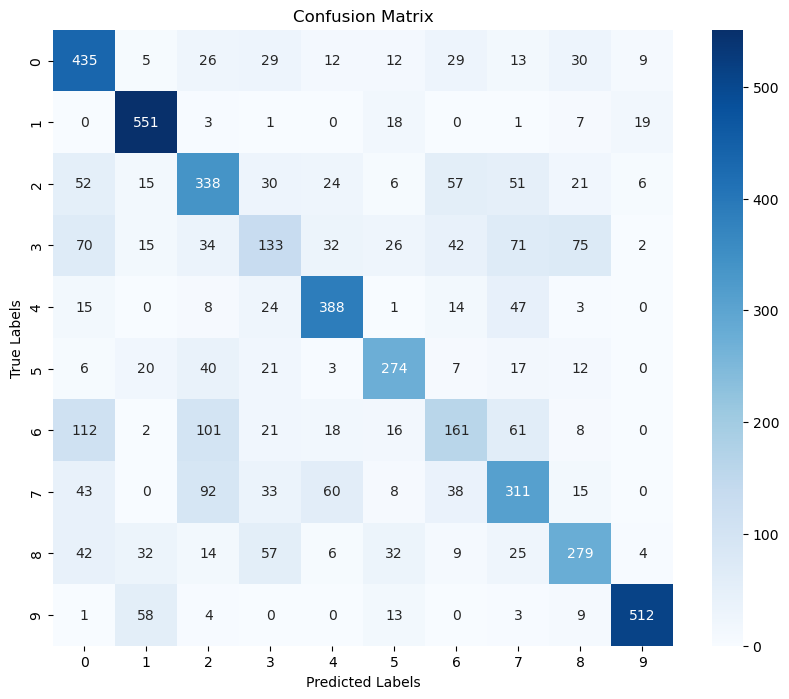

In [24]:
# Plotting
import seaborn as sns
plt.figure(figsize=(10, 8))

# Heatmap for Confusion Matrix
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
